# Clustering images

In this example there are images of flowers from the 17 Category Flower Dataset (https://www.robots.ox.ac.uk/~vgg/data/flowers/17/) clustered.  

Note that this does only work well on images of the same object from the same angle.
The Clustering task is then to cluster all images of that same object into an own cluster.
It does not work on images that should be for example clustered into Cats and Dogs.

It is assumed that the images are in a folder with the following structure:
```
data
  folder_with_images_cluster_0
    image_0
    image_1
  folder_with_images_cluster_1
    image_0
    image_1
  folder_with_images_cluster_2
    ...
    ...
  
```

### Data functions
These functions are needed to load the images from the folder, copmpute their image features as well as the similarity matrix.

In [20]:
import random as rng
import sys
import os
import numpy as np
def data_cluster_images_static(
    data_folder, num_clusters, num_images_per_cluster, seed=3
):
    """
    Will generate num_clusters clusters with num_images_per_cluster pictures each
    """
    # get the cars
    car_dir_names = sorted(os.listdir(data_folder), key=lambda x: x)

    # remove ipycheckpoint
    if car_dir_names[0] == ".ipynb_checkpoints":
        car_dir_names = car_dir_names[1::]

    # make a random shuffle of the cars/folders to take
    rng.seed(seed)
    cars_to_take = rng.sample(car_dir_names, len(car_dir_names))
    cars_to_take = cars_to_take[0:num_clusters:]

    # make the cluster data and the labels
    # generate num_clusters and add num_images_per_cluster to each cluster
    cluster_image: list = []
    cluster_labels: list = []

    label_counter = 0
    for car_folder in cars_to_take:
        # take images and shuffle them
        imgs = sorted(os.listdir(data_folder + "/" + car_folder), key=lambda x: x)
        imgs = rng.sample(imgs, len(imgs))

        # make data and labels
        # add the respectiv car folder as path
        cluster_image = cluster_image + [
            str(car_folder) + "/" + image for image in imgs[0:num_images_per_cluster:]
        ]
        cluster_labels = cluster_labels + [label_counter] * num_images_per_cluster
        label_counter += 1

    # read the images as opencv images from disk
    image_data = []
    for image_file in cluster_image:
        #print("Reading_Image: ", data_folder + "/" + image_file)
        image_data.append(
            [cv.imread(data_folder + "/" + image_file, cv.IMREAD_GRAYSCALE)]
        )

    return cluster_image, image_data, cluster_labels


def compute_orb_image_features(images, image_resize_size):
    """Computes and returns the OpenCV ORB image feature descriptors"""
    # Initiate ORB detector for feature extraction
    orb = cv.ORB_create()
    descriptors = []
    # compute key points and descriptors
    for image in images:
        img = image[0]
        img = cv.resize(img, image_resize_size)
        kp, des = orb.detectAndCompute(img, None)
        descriptors.append([des])

    return descriptors

# example code

In [21]:
# ----------------------
#       imports
# ----------------------
# import sklearn distance function
from sklearn.metrics.pairwise import manhattan_distances
# import opencv
import cv2 as cv
# matplotlib
import matplotlib.pyplot as plt

# make AntClus dir known
import sys
sys.path.append("../AntClust")
# import AntClust
from AntClust import AntClust
# import the precomputed distance matrix function for AntClust
from distance_classes import precomputed_similarity_matrix, opencv_orb_similarity
# import the rule set
from rules import labroche_rules

# ----------------------
#       data
# ----------------------
data_folder = "Flower_Images"
num_clust = 3
images_per_cluster = 3
image_resize_size = (553, 500)
image_names, images, labels = data_cluster_images_static(
    data_folder, num_clust, images_per_cluster
)
# print(type(image_names),image_names)
# print(type(images),images)
# print(type(labels),labels)

image_orbs = compute_orb_image_features(images, image_resize_size)
data = np.array(image_orbs, dtype=list)
labels = np.array(labels)
print(data[0])

# distance matrix for sklearn
orb_sim = opencv_orb_similarity()
distance_matrix = []
for i in range(len(data)):
    t_l = []
    for n in range(len(data)):
        t_l.append(orb_sim.similarity(data[i][0], data[n][0]))
    distance_matrix.append(t_l)
# sklearn needs it in the way that 0 means a==b
# ant clust needs it in the way 1 means a==b
distance_matrix = 1 - np.array(distance_matrix)

# AntClust needs every data tuple as an array.
# e.g. [1,2,3] needs to be [[1],[2],[3]]
distance_matrix = [[i] for i in distance_matrix]


[array([[201, 136, 181, ..., 228, 203,  13],
        [231, 172, 132, ..., 108, 219,  92],
        [192, 104,  30, ...,   8, 109,   2],
        ...,
        [194, 164, 150, ...,  68, 165, 218],
        [ 19, 159,  91, ..., 136, 225, 153],
        [  3, 182, 153, ..., 200, 161, 249]], dtype=uint8)]


In [22]:


# ----------------------
#       AntClust
# ----------------------
# tell AntClust to treat the data set as precomputed similarity matrix
# similarity function
f_sim = [precomputed_similarity_matrix()]
ant_clust = AntClust(f_sim, labroche_rules())

# find clusters by using the distance matrix of the data
ant_clust.fit(distance_matrix)

# get the clustering result
clusters_found = ant_clust.labels_
clusters_found_orb = ant_clust.get_clusters()

AntClust: phase 1 of 3 -> meeting ants
Meeting 675 / 675
Meeting 540 / 675
Meeting 405 / 675
Meeting 270 / 675
Meeting 135 / 675
AntClust: phase 2 of 3 -> shrink nests
AntClust: phase 3 of 3 -> reassign ants


# AntClust with Cosine Similarity

In [23]:
image_names, images, labels = data_cluster_images_static(
    data_folder, num_clust, images_per_cluster
)

In [24]:
# ----------------------
#       imports
# ----------------------
# import opencv
import cv2 as cv
# matplotlib
import matplotlib.pyplot as plt

# make AntClus dir known
import sys
sys.path.append("../AntClust")
# import AntClust
from AntClust import AntClust
# import the precomputed distance matrix function for AntClust
from distance_classes import image_cosine_similarity
# import the rule set
from rules import labroche_rules

# ----------------------
#       AntClust
# ----------------------
# tell AntClust to treat the data set as precomputed similarity matrix
# similarity function
path_img = "../Examples/Flower_Images/"
f_sim = [image_cosine_similarity(path_img,image_names)]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
ant_clust = AntClust(f_sim, labroche_rules())

# find clusters by using the distance matrix of the data

ant_clust.fit([[i] for i in range(len(image_names))])

# get the clustering result
clusters_found_cosine = ant_clust.get_clusters()

AntClust: phase 1 of 3 -> meeting ants
Meeting 675 / 675
Meeting 540 / 675
Meeting 405 / 675
Meeting 270 / 675
Meeting 135 / 675
AntClust: phase 2 of 3 -> shrink nests
AntClust: phase 3 of 3 -> reassign ants


# K-means

In [26]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import shutil

# Function to Extract features from the images
def image_feature(direc):
    model = InceptionV3(weights='imagenet', include_top=False)
    features = []
    img_name = []

    for i in tqdm(direc,disable=True):
        fname="../Examples/Flower_Images/"+i
        img=image.load_img(fname,target_size=(224,224))
        x = img_to_array(img)
        x=np.expand_dims(x,axis=0)
        x=preprocess_input(x)
        feat=model.predict(x)
        feat=feat.flatten()
        features.append(feat)
        img_name.append(i)
    return features,img_name

img_features,img_name=image_feature(image_names)

1/1 [==============================] - 0s 190ms/step


In [27]:
#Creating Clusters
k = 3 # number of clusters in dataset
clusters = KMeans(k, random_state = 40)
clusters.fit(img_features)
correct = 0


# Metrics

In [30]:
from sklearn.metrics import adjusted_rand_score
ari_ant_cos = adjusted_rand_score(labels, clusters_found_cosine)
ari_kmeans = adjusted_rand_score(labels, clusters.labels_)
ari_ant_orb = adjusted_rand_score(labels, clusters_found_orb)

print(f"ARI for AntClust (Cosine Similarity): {ari_ant_cos}")
print(f"ARI for AntClust (ORB Similarity): {ari_ant_orb}")
print(f"ARI for K-means (k={k}): {ari_kmeans}")

ARI for AntClust (Cosine Similarity): 1.0
ARI for AntClust (ORB Similarity): 0.1111111111111111
ARI for K-means (k=3): 1.0


# Print the labels to the images

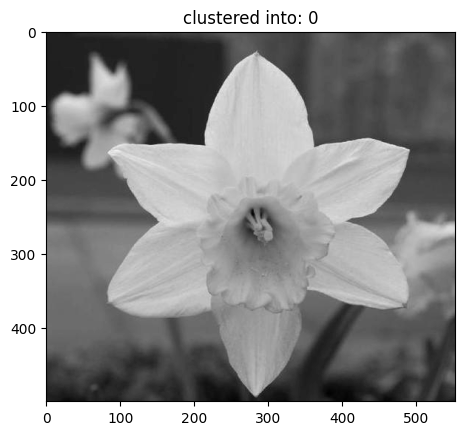

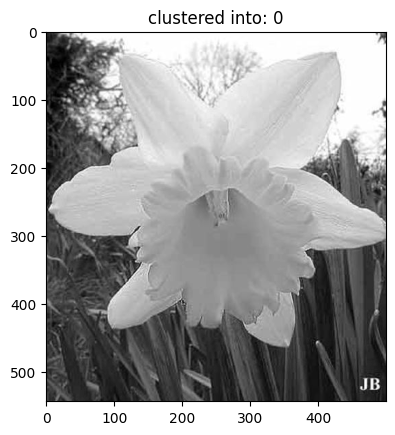

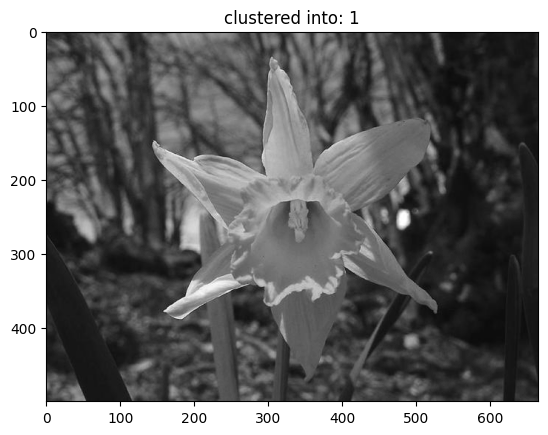

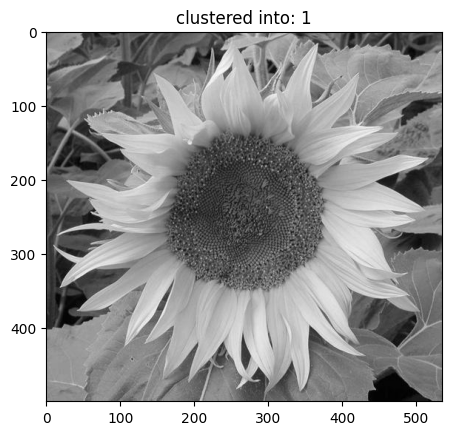

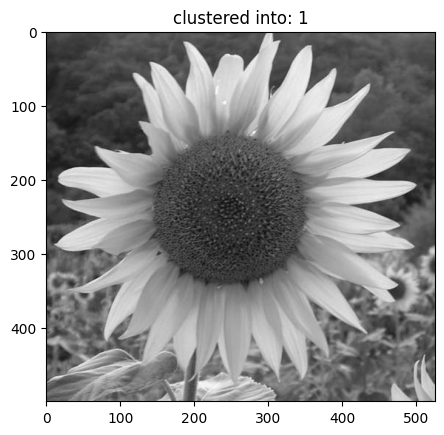

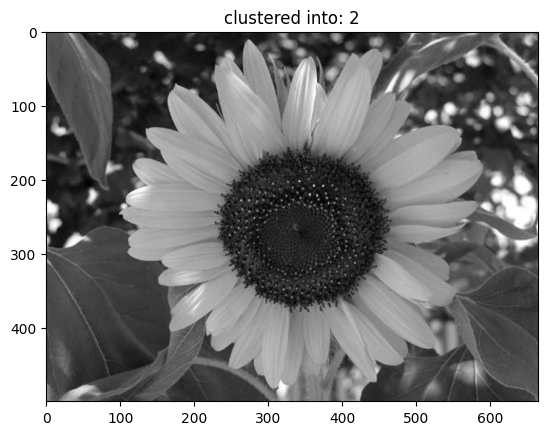

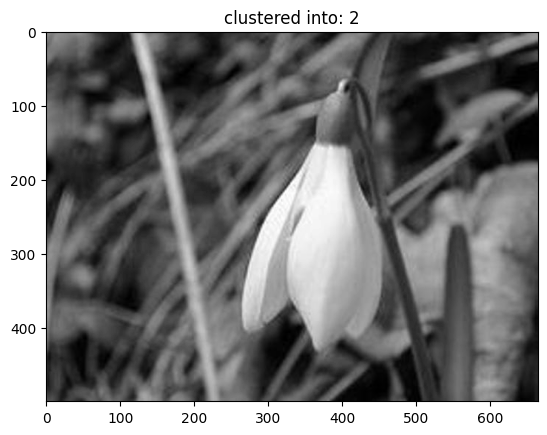

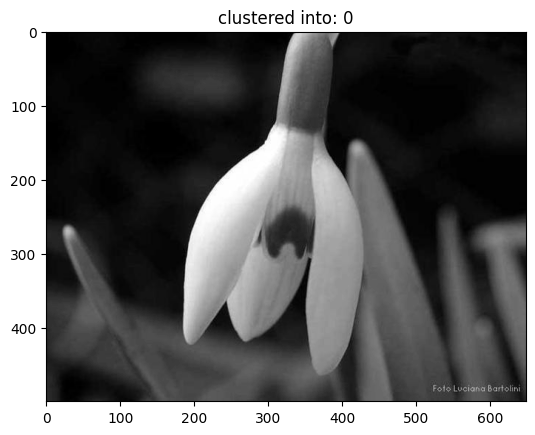

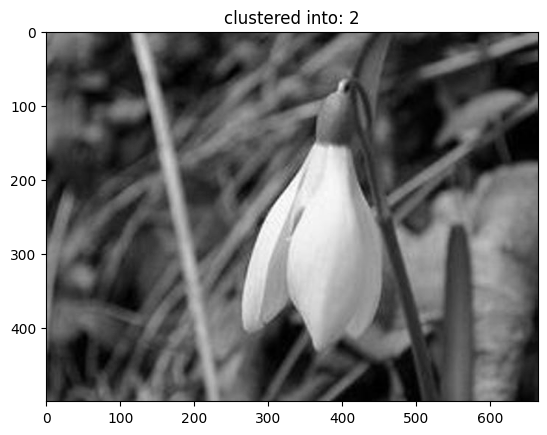

In [ ]:
# for image, l in zip(images, clusters_found):
#     #print(image)
#     plt.imshow(image[0], cmap='gray')
#     plt.title(f'clustered into: {l}')
#     plt.show()